# Fixation Explore in Python

This notebook was created to grab data from matlab and use it in python. The ultimate goal is to use the functions developed in this notebook to build a Pytorch Dataset object. The get_item method will serve one fixation [1?, 1 channel, H, W, #Fixation Points], spike rates = #fixation points/#neurons = matrix (#fixation points, #neurons). Each trial is one image. The end goal of the object is to use any trajectory and grid sample.

## Imports

In [1]:
import numpy as np
import matlab.engine

import matplotlib.pyplot as plt
import torch

import os
from PIL import Image
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

from IPython.display import Image as IPythonDisplay
import imageio

# import torchvision.transforms.functional as F
# to_image = F.to_pil_image

ModuleNotFoundError: No module named 'matlab'

## Matlab Setup

We will use matlab engine to run matlab code in python and grab the global variables to use in python code.

In [9]:
eng = matlab.engine.start_matlab()

eng.addpath('', nargout=0)
eng.addpath('scripts/', nargout=0)
eng.eval("addFreeViewingPaths('tejaslaptop')")

mat_file_path = '~/Documents/data/mitchell/allen_20220610.mat'
eng.eval(f"Exp=load('{mat_file_path}')", nargout=0)

In [10]:
matlab_script = "stimulusSet = 'BackImage';\
validTrials = io.getValidTrials(Exp, stimulusSet);\
tstart = Exp.ptb2Ephys(cellfun(@(x) x.STARTCLOCKTIME, Exp.D(validTrials)));\
tstop = Exp.ptb2Ephys(cellfun(@(x) x.ENDCLOCKTIME, Exp.D(validTrials)));\
fixon = Exp.vpx2ephys(Exp.slist(1:end-1,2));\
sacon = Exp.vpx2ephys(Exp.slist(2:end,1));\
eyeTime = Exp.vpx2ephys(Exp.vpx.smo(:,1));\
eyeX = Exp.vpx.smo(:,2);\
eyeY = Exp.vpx.smo(:,3);\
ppd = Exp.S.pixPerDeg;\
ctr = Exp.S.centerPix;\
win = [0.05 0];\
ppd = Exp.S.pixPerDeg;\
ctr = Exp.S.centerPix;\
rect = [-1 -1 1 1]*ceil(ppd*1);\
dims = [rect(4)-rect(2) rect(3)-rect(1)];"

eng.eval(matlab_script, nargout=0)

In [11]:
validTrials = np.array(eng.workspace['validTrials']).astype(int).squeeze()
ppd = eng.eval('Exp.S.pixPerDeg;')
ctr = np.array(eng.eval('Exp.S.centerPix;')).squeeze()
eyeX = torch.Tensor(eng.eval('Exp.vpx.smo(:,2);')) #change from np.array
eyeY= torch.Tensor(eng.eval('Exp.vpx.smo(:,3);')) #change from np.array
fixon = np.array(eng.workspace['fixon']).squeeze()
sacon = np.array(eng.workspace['sacon']).squeeze()
eyeTime = np.array(eng.workspace['eyeTime']).squeeze()
win = np.array(eng.workspace['win']).squeeze()
tstart = np.array(eng.workspace['tstart']).squeeze()
tstop = np.array(eng.workspace['tstop']).squeeze()
Exp_osp_st = np.array(eng.eval('Exp.osp.st')).squeeze()
Exp_osp_clu = np.array(eng.eval('Exp.osp.clu')).squeeze()


### Total Number of Fixations

In [12]:
def get_idx_to_iTrial_and_ifix():
    total = 0
    idx_to_iTrial_and_ifix = []
    for iTrial in range(1, len(validTrials) + 1):
        fixix = np.where((fixon > tstart[iTrial - 1]) & (fixon < tstop[iTrial - 1]))[0]
        total += len(fixix)

        iTrial_and_ifix = np.stack((np.ones(len(fixix)) *iTrial, (np.arange(len(fixix)) + 1)), axis = -1).astype(int).tolist()

        idx_to_iTrial_and_ifix.extend(iTrial_and_ifix)

    assert len(idx_to_iTrial_and_ifix) == total

    return idx_to_iTrial_and_ifix
len(get_idx_to_iTrial_and_ifix()), get_idx_to_iTrial_and_ifix()

(3816,
 [[1, 1],
  [1, 2],
  [1, 3],
  [1, 4],
  [1, 5],
  [1, 6],
  [1, 7],
  [1, 8],
  [1, 9],
  [1, 10],
  [1, 11],
  [1, 12],
  [1, 13],
  [1, 14],
  [1, 15],
  [1, 16],
  [1, 17],
  [1, 18],
  [1, 19],
  [1, 20],
  [1, 21],
  [1, 22],
  [1, 23],
  [1, 24],
  [1, 25],
  [1, 26],
  [1, 27],
  [1, 28],
  [1, 29],
  [1, 30],
  [1, 31],
  [2, 1],
  [2, 2],
  [2, 3],
  [2, 4],
  [2, 5],
  [2, 6],
  [2, 7],
  [2, 8],
  [2, 9],
  [2, 10],
  [2, 11],
  [2, 12],
  [2, 13],
  [2, 14],
  [2, 15],
  [2, 16],
  [2, 17],
  [2, 18],
  [2, 19],
  [2, 20],
  [2, 21],
  [2, 22],
  [2, 23],
  [2, 24],
  [2, 25],
  [2, 26],
  [2, 27],
  [2, 28],
  [2, 29],
  [3, 1],
  [3, 2],
  [3, 3],
  [3, 4],
  [3, 5],
  [3, 6],
  [3, 7],
  [3, 8],
  [3, 9],
  [3, 10],
  [3, 11],
  [3, 12],
  [3, 13],
  [3, 14],
  [3, 15],
  [3, 16],
  [3, 17],
  [3, 18],
  [3, 19],
  [3, 20],
  [3, 21],
  [3, 22],
  [3, 23],
  [3, 24],
  [3, 25],
  [3, 26],
  [3, 27],
  [3, 28],
  [3, 29],
  [3, 30],
  [3, 31],
  [3, 32],
  [3, 33

## Image Fetching

In [13]:
def get_im_tensor_from_file(iTrial):
    assert iTrial > 0, 'give ifix index in matlab indexing (1, 2, 3 ...)'
    # iTrial = trial_number
    thisTrial = validTrials[iTrial-1]
    # iTrial = 12
    # thisTrial = 320
    # print(iTrial, thisTrial)

    width, height = np.array(eng.eval('Exp.S.screenRect(3:4)')).astype(int).squeeze()

    try:
        image_file_path = eng.eval('Exp.D{{{}}}.PR.imagefile'.format(thisTrial))
        marmo_v5_path = '/Users/tejasvikothapalli/Documents/MarmoV5/'
        image_file_path = os.path.join(marmo_v5_path, image_file_path)
        # print(image_file_path)
        Im = Image.open(image_file_path)
    except:
        try:
            image_file_path = os.path.join(marmo_v5_path, image_file_path.replace('\\', os.path.sep))
            Im = Image.open(image_file_path)
        except:
            raise ValueError("regenerateStimulus: failed to load image")

    transform_to_pytorch = transforms.ToTensor()
    Im = F.resize(Im, (height, width))
    Im_tensor = transform_to_pytorch(Im)
    Im_tensor = Im_tensor * 255
    Im_tensor = Im_tensor.mean(dim =0, keepdim=True) - 127

    return Im_tensor #[1 channel, H, W]



/Users/tejasvikothapalli/opt/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:63: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


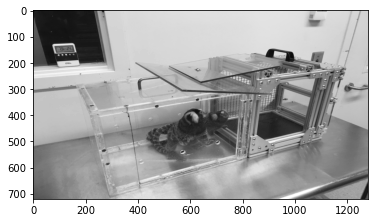

In [14]:
iTrial=12
Im_tensor = get_im_tensor_from_file(iTrial)
Img_plt = Im_tensor.numpy().squeeze()
plt.imshow(Img_plt, cmap = 'gray')
plt.show()

## Trial Trajectory Fetching

In [15]:
# eyeix = np.array(eng.eval('eyeTime > tstart({}) & eyeTime < tstop({})'.format(iTrial, iTrial))).squeeze()
def get_eyeXPix_and_eyeYPix_trajectory(iTrial):
    assert iTrial > 0, 'give iTrial index in matlab indexing (1, 2, 3 ...)'
    eyeix = (eyeTime > tstart[iTrial - 1]) & (eyeTime < tstop[iTrial - 1])
    eyeXPix = eyeX[eyeix]*ppd + ctr[0]
    eyeYPix = -eyeY[eyeix]*ppd + ctr[1]

    return eyeXPix, eyeYPix

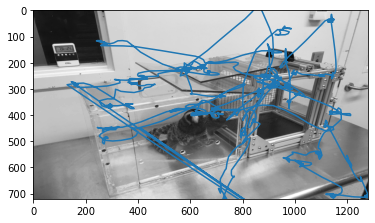

In [16]:
eyeXPix, eyeYPix = get_eyeXPix_and_eyeYPix_trajectory(iTrial)

Img_plt = Im_tensor.numpy().squeeze()
plt.imshow(Img_plt, cmap = 'gray')
plt.plot(eyeXPix, eyeYPix)
plt.xlim(0, Img_plt.shape[1])
plt.ylim(Img_plt.shape[0], 0)
plt.show()


## Spikes for Fixation

In [17]:
#Extra code
# iTrial = 12
# ifix = 10
# matlab_spike_script = "spkix = Exp.osp.st > tstart({}) & Exp.osp.st < tstop({});\
# st = Exp.osp.st(spkix);\
# clu = Exp.osp.clu(spkix);\
# thisfix = fixix({});\
# iix = st > fixon(thisfix)+win(1) & st < sacon(thisfix)+win(2);".format(iTrial, iTrial, ifix)

# eng.eval(matlab_spike_script, nargout = 0)
# st = np.array(eng.workspace['st']).squeeze()
# clu = np.array(eng.workspace['clu']).squeeze()

# iix = np.array(eng.workspace['iix']).squeeze()

# imrect = np.array(eng.workspace['imrect']).squeeze()
# #The first two elements of imrect are the top-left corner coordinates (horizontal, vertical), 
# #while the last two elements represent the width and height of the rectangle, respectively.
# horizontal, vertical, width_fixation, height_fixation = imrect.round().astype(int)
# # horizontal, vertical, width_fixation, height_fixation = imrect_all[24,...].round().int()
# # horizontal, vertical= 0, 0

# #image crop to fixation
# fixation_crop = Im_tensor[:, vertical: vertical + height_fixation, horizontal: horizontal + width_fixation]
# plt.imshow(fixation_crop.numpy().squeeze(), cmap = 'gray')
# plt.show()

# torch.isclose(get_fixation_xy(ifix, iTrial), center_locations_fixations).all()

# ifix = 3
# matlab_script_for_each_fixation =  "thisfix = fixix({});\
# ii = eyeTime > fixon(thisfix)+win(1) & eyeTime < sacon(thisfix)+win(2);\
# et = eyeTime(ii);\
# fixX = eyeX(ii)*ppd + ctr(1);\
# fixY = -eyeY(ii)*ppd + ctr(2);\
# i = ceil(numel(et)/2);\
# tmprect = rect + [fixX(i) fixY(i) fixX(i) fixY(i)];\
# imrect = [tmprect(1:2) (tmprect(3)-tmprect(1))-1 (tmprect(4)-tmprect(2))-1];".format(ifix)
# eng.eval(matlab_script_for_each_fixation, nargout=0)

# rect = torch.tensor(eng.workspace['rect']).squeeze()
# fixX = torch.tensor(eng.workspace['fixX']).squeeze()
# fixY = torch.tensor(eng.workspace['fixY']).squeeze()

# tmprect_all = torch.stack((fixX, fixY, fixX, fixY), dim = -1) + rect
# center_locations_fixations = torch.stack((fixX, fixY), dim =-1) #horizontal, vertical
# imrect_all = torch.stack((tmprect_all[:, 0], 
#                           tmprect_all[:, 1], 
#                           (tmprect_all[:, 2] - tmprect_all[:, 0]) -1,
#                           (tmprect_all[:, 3] - tmprect_all[:, 1]) -1), dim = -1)

# imrect_all.size()

In [18]:
def plot_spike_times(st, clu):
    unique_clusters = np.unique(clu)
    clustered_st = [st[clu == cluster_id] for cluster_id in unique_clusters]

    # Adjust the cluster IDs by adding 10
    clu_adjusted = unique_clusters + 10

    # Create a raster plot
    plt.figure()
    plt.eventplot(clustered_st, lineoffsets=clu_adjusted, linelengths=1, color='k', linewidth=2)

    # Customize plot (optional)
    plt.xlabel('Time')
    plt.ylabel('Cluster ID')
    plt.title('Raster plot')

    # Display the plot
    plt.show()
# plot_spike_times(st[iix], clu[iix])

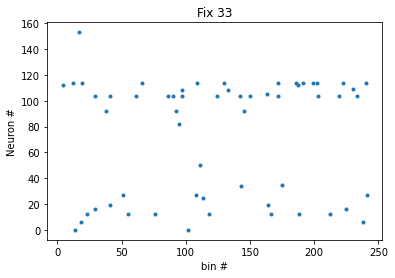

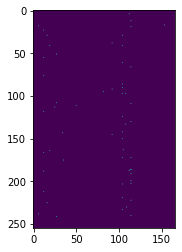

In [75]:
NC = np.max(np.unique(Exp_osp_clu))

def spikes_for_fixation(ifix, iTrial, nbins=500, binsize=1e-3):

    

    spkix = (Exp_osp_st > tstart[iTrial - 1]) & (Exp_osp_st < tstop[iTrial - 1])
    st = Exp_osp_st[spkix]
    clu = Exp_osp_clu[spkix]
    fixix = np.where((fixon > tstart[iTrial - 1]) & (fixon < tstop[iTrial - 1]))[0]
    # eng.eval('fixix=find(fixon > tstart({}) & fixon < tstop({}));'.format(iTrial, iTrial), nargout =0)
    thisfix = fixix[ifix-1]

    fix_end = (sacon[thisfix]+win[1])
    fix_start = (fixon[thisfix]+win[0])
    fix_duration = fix_end-fix_start
    fix_duration = np.minimum(nbins*binsize, fix_duration)

    iix = (st > fix_start) & (st < (fix_start + fix_duration - binsize))
    # (iix == iix_np).all()

    st_fixation = st[iix] - fix_start #spike times, st[ix] for this fixation
    clu_fixation = clu[iix] ##clu is cluster id
    # map cluster id to a unit number
    # clu = self.spike_indices[expt]['unit ids map'][clu] #gets rid of neurons that are not in the dataset


    #get number of fixation
    # fixix = np.where((fixon > tstart[iTrial - 1]) & (fixon < tstop[iTrial - 1]))[0]
    # thisfix = fixix[ifix-1]

    # ii = (eyeTime > (fixon[thisfix] + win[0])) & (eyeTime < (sacon[thisfix] + win[1]))
    # #get number of fixation

    # frame_times = eyeTime[ii] # of time points in one fixations

    # NC = len(np.unique(clu_fixation))#number of neurons

    
    frame_times = np.arange(0, fix_duration, binsize)

    # print(frame_times[:])
    # print(st_fixation[:])

    # print(np.digitize(st_fixation, frame_times))

    st_fixation_digitized = np.digitize(st_fixation, frame_times)
    st_valid_indexer = (st_fixation_digitized != 0) & (st_fixation_digitized != len(frame_times))
    assert st_valid_indexer.all()
    # print(len(frame_times))
    # print(st_valid_indexer)
    clu_fixation_valid = clu_fixation[st_valid_indexer]
    st_fixation_valid = st_fixation[st_valid_indexer]
    st_fixation_digitized_valid = st_fixation_digitized[st_valid_indexer] - 1
    # print(st_fixation_digitized_valid)

    # robs_tmp = torch.sparse_coo_tensor(np.asarray([np.digitize(st_fixation, frame_times)-1, clu_fixation]), #fastest way to bin/hist things
    #                         np.ones(len(clu_fixation)), (len(frame_times), NC) , dtype=torch.float32)
    robs_tmp = torch.sparse_coo_tensor(np.asarray([st_fixation_digitized_valid, clu_fixation_valid]), #fastest way to bin/hist things
                            np.ones(len(clu_fixation_valid)), (len(frame_times), NC) , dtype=torch.float32)
    robs_tmp = robs_tmp.to_dense()#.numpy() #.astype(np.int8)

    return robs_tmp
iTrial =  12
ifix += 1
spks = spikes_for_fixation(ifix, iTrial)

i,j = np.where(spks)
plt.plot(i, j, '.')
plt.xlabel("bin #")
plt.ylabel("Neuron #")
plt.title("Fix %d" %ifix)
plt.show()

plt.imshow(spks.numpy())

# print(NC)


## Image Patches for Fixation

In [20]:
def get_fixation_xy(ifix, iTrial):
    assert ifix > 0, 'give ifix index in matlab indexing (1, 2, 3 ...)'
    assert iTrial > 0, 'give iTrial index in matlab indexing (1, 2, 3 ...)'
    fixix = np.where((fixon > tstart[iTrial - 1]) & (fixon < tstop[iTrial - 1]))[0]
    thisfix = fixix[ifix-1]
    ii = (eyeTime > (fixon[thisfix] + win[0])) & (eyeTime < (sacon[thisfix] + win[1]))
    # et = eyeTime[ii]

    # eyeix = np.array(eng.eval('eyeTime > tstart({}) & eyeTime < tstop({})'.format(iTrial, iTrial))).squeeze()
    eyeix = (eyeTime > tstart[iTrial - 1]) & (eyeTime < tstop[iTrial - 1])
    eyeXPix = eyeX[eyeix]*ppd + ctr[0]
    eyeYPix = -eyeY[eyeix]*ppd + ctr[1]
    
    fixX = eyeX[ii]*ppd + ctr[0]
    fixY = -1*eyeY[ii]*ppd + ctr[1]
    return torch.stack((fixX, fixY), dim =-1).squeeze()

/Users/tejasvikothapalli/opt/anaconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


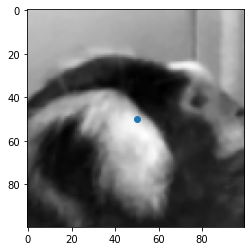

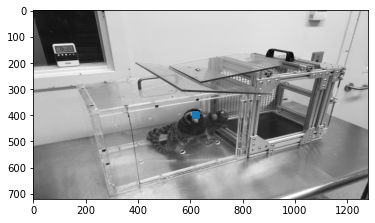

In [21]:
def get_trajectory_patches_from_image(Im_tensor, patch_locations_tensor):
    """
        Add two numbers and return the result.

        Args:
            Im_tensor (tensor): Image tensor with shape [1 channel, Height, Width]
            patch_locations_tensor (tensor): 

        Returns:
            tensor: The sampled patches for the fixation/traj

        Examples:
            >>> obj = MyClass()
            >>> obj.my_method(2, 3)
            5
    """
    Im_tensor_with_batch = Im_tensor.unsqueeze(0)
    # patch_locations_tensor = torch.flip(imrect_all[:, :2], dims = (-1,)) #(vertical, horizontal)
    # patch_locations_tensor = get_fixation_xy(10, iTrial) #(x,y)
    # patch_locations_tensor = get_fixation_xy(ifix-1)
    height, width = Im_tensor_with_batch.shape[2:]
    # patch_width, patch_height = imrect_all[0, 2].int().item() , imrect_all[0, 3].int().item()
    patch_width, patch_height= np.ceil(ppd) * 2 - 1, np.ceil(ppd) * 2 - 1
    # assert (imrect_all[:, 2:] - torch.tensor([patch_width, patch_height]) == 0).all().item()


    vertical_center = height/2
    horizontal_center = width/2

    # patch_locations_tensor  = patch_locations_tensor[[0], :]
    # patch_locations_tensor[0, 0] = horizontal_center
    # patch_locations_tensor[0, 1] = vertical_center


    aspect_ratio = height/width

    #use (x, y)


    num_patches = len(patch_locations_tensor)

    Ngrid = 100 #this is too high

    #each grid mark should be roughly a pixel

    # generate a 2D grid and move it along a trajectory, then use grid_sample to sample from the image
    xx,yy = torch.meshgrid(torch.linspace(-1* aspect_ratio, 1* aspect_ratio, Ngrid), torch.linspace(-1, 1 , Ngrid))
    # xx,yy = torch.meshgrid(torch.linspace(-1, 1, Ngrid), torch.linspace(-1* aspect_ratio, 1 * aspect_ratio, Ngrid))

    grid = torch.stack((xx.flatten(), yy.flatten()), dim=1) #(x,y)
    grid *= 1 * patch_height/height


    patch_locations_tensor_normalized = (patch_locations_tensor - \
                                        torch.tensor([horizontal_center, vertical_center]))/\
                                            torch.tensor([horizontal_center, vertical_center]) #(x, y)

    # patch_locations_tensor_normalized = torch.flip(patch_locations_tensor_normalized, dims = (-1,)) #(y,x)

    full_grid = grid.unsqueeze(1) + patch_locations_tensor_normalized.unsqueeze(0) #range 0 to 1

    full_grid = full_grid.unsqueeze(0) #[1 example, Ngrid**2, number of patches, 2 channels for x&y]

    coneinputs = torch.nn.functional.grid_sample(Im_tensor_with_batch, 
                                                    full_grid, 
                                                    # torch.flip(full_grid, dims = (-1,)),
                                                    mode='bilinear', 
                                                    align_corners=False)
    sampled_patches = coneinputs.reshape(1, 1, Ngrid, Ngrid, num_patches).transpose(2, 3).squeeze(dim=0) #go from (x, y) to (y, x)

    return sampled_patches

patch_locations_tensor = get_fixation_xy(3, iTrial)
sampled_patches = get_trajectory_patches_from_image(Im_tensor, patch_locations_tensor)
plt.imshow(sampled_patches[..., 0].squeeze().numpy(), cmap = 'gray')

patch_x_mid, patch_y_mid = sampled_patches.shape[1]//2, sampled_patches.shape[2]//2
plt.scatter(patch_x_mid, patch_y_mid)
plt.show()

plt.imshow(Im_tensor.numpy().squeeze(), cmap = 'gray')
plt.scatter(patch_locations_tensor[:, 0], patch_locations_tensor[:, 1])
plt.xlim()
plt.show()

In [22]:
def make_fixation_gif(sampled_patches, file_name):
    Frames = []
    num_patches = sampled_patches.shape[-1]
    for f in range(num_patches):
        s = sampled_patches[..., f].squeeze().unsqueeze(0)
        s = (s - s.min())/(s.max() - s.min())
        Frames.append(to_image(s))
        # Frames.append(s)
    # plt.imshow(M[:,:,:, :, f].squeeze().T, aspect='auto', interpolation='none')
    # plt.show()
    imageio.mimsave(file_name, Frames, fps=10)

In [23]:
make_fixation_gif(sampled_patches, 'test.gif')

NameError: name 'to_image' is not defined

## Put it all Together

/Users/tejasvikothapalli/opt/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:63: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


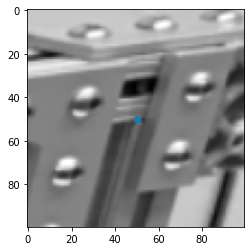

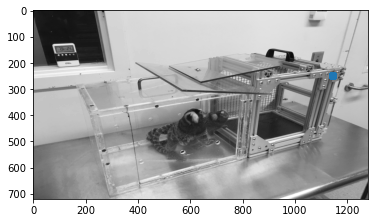

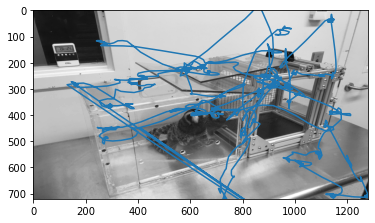

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
iTrial = 12
ifix = 10
patch_locations_tensor = get_fixation_xy(ifix, iTrial)
Im_tensor = get_im_tensor_from_file(iTrial)
Img_plt = Im_tensor.numpy().squeeze()

sampled_patches = get_trajectory_patches_from_image(Im_tensor, patch_locations_tensor)
plt.imshow(sampled_patches[..., 0].squeeze().numpy(), cmap = 'gray')

patch_x_mid, patch_y_mid = sampled_patches.shape[1]//2, sampled_patches.shape[2]//2
plt.scatter(patch_x_mid, patch_y_mid)
plt.show()

plt.imshow(Img_plt, cmap = 'gray')
plt.scatter(patch_locations_tensor[:, 0], patch_locations_tensor[:, 1])
plt.xlim()
plt.show()


plt.imshow(Img_plt, cmap = 'gray')
eyeXPix, eyeYPix = get_eyeXPix_and_eyeYPix_trajectory(iTrial)
plt.plot(eyeXPix, eyeYPix)
plt.xlim(0, Img_plt.shape[1])
plt.ylim(Img_plt.shape[0], 0)
plt.show()

print(spikes_for_fixation(ifix, iTrial))

gif_file_name = 'temp.gif'
assert os.path.exists(gif_file_name)
if os.path.exists(gif_file_name): os.remove(gif_file_name)
make_fixation_gif(sampled_patches, gif_file_name)




In [ ]:
IPythonDisplay(url=gif_file_name)  